<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/Testing_different_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 1.4MB/s 
     |████████████████████████████████| 2.1MB 7.1MB/s 
     |████████████████████████████████| 8.7MB 14.8MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/KSchool-Master-Final-Project'       # path to your project on Drive

drive.mount(ROOT)           # we mount the drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import numpy as np
import statsmodels.api as sm
import math
import pmdarima as pm

In [4]:
%pwd

'/content'

In [5]:
%cd drive/My Drive/KSchool-Master-Final-Project

/content/drive/My Drive/KSchool-Master-Final-Project


In [6]:
covid = pd.read_csv('data/owid-covid-data 20200713.csv', parse_dates=["date"])

covid_eur = covid[covid['continent']=='Europe']

covid_esp = covid_eur[covid_eur["location"]=="Spain"].reset_index()

indexes = covid_esp[(covid_esp["new_cases"]<0) &(covid_esp["location"]=="Spain")].index.values
#sustituir por la media de valores anterior y posterior
#for i in indexes:
#  covid_esp.iloc[i,6]= (covid_esp.iloc[i+1,6]+covid_esp.iloc[i-1,6])/2

covid_esp.index = covid_esp.date
covid_esp_newcases = covid_esp["new_cases"]
covid_esp_newcases = covid_esp_newcases.resample('D').sum()

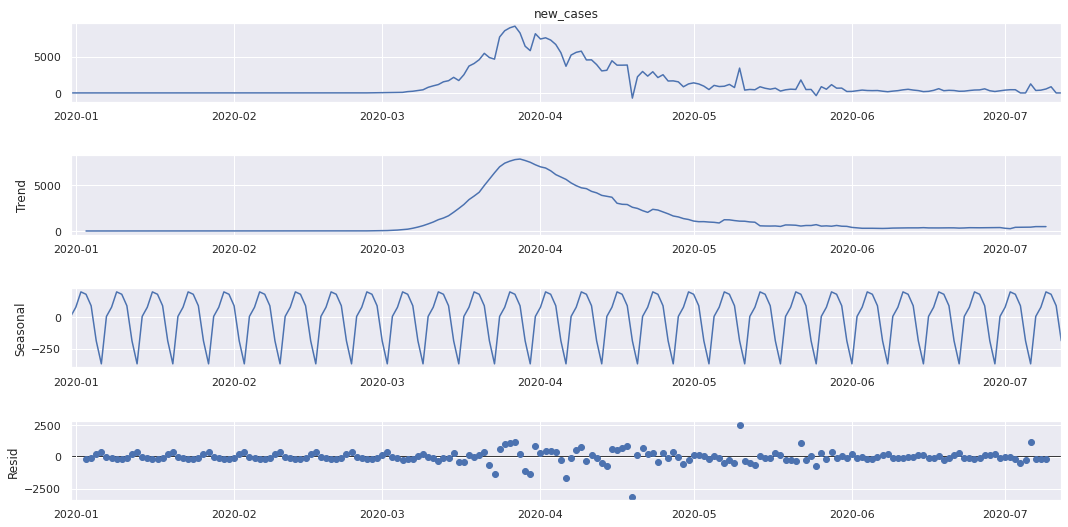

In [7]:
res = sm.tsa.seasonal_decompose(covid_esp_newcases)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

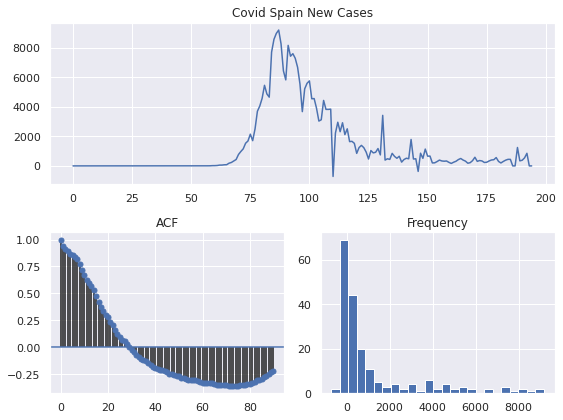

In [8]:
pm.tsdisplay(covid_esp_newcases, lag_max=90, title="Covid Spain New Cases", show=True)

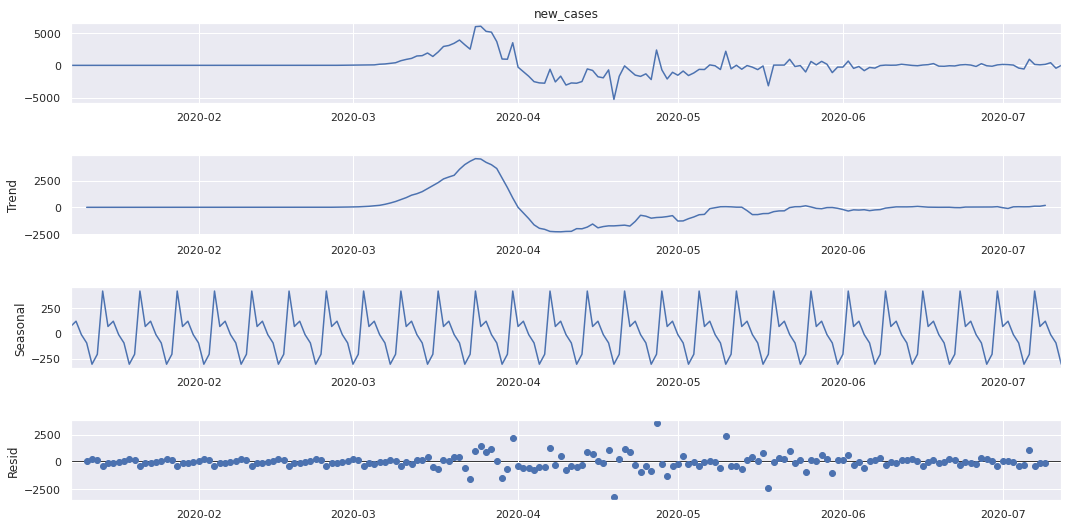

In [9]:
covid_esp_diff8 = covid_esp_newcases.diff(8)

res = sm.tsa.seasonal_decompose(covid_esp_diff8.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

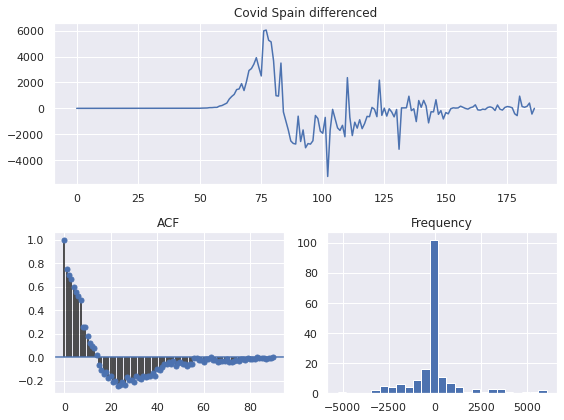

In [10]:
pm.tsdisplay(covid_esp_diff8[8:], lag_max=90, title="Covid Spain differenced", show=True)

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

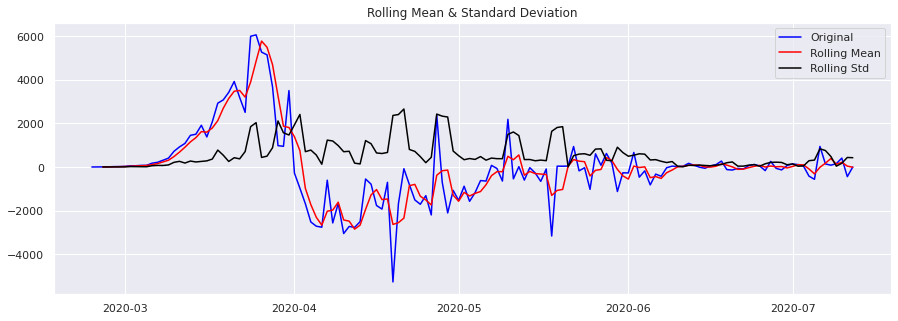

Result of Dicky=Fuller Test
Test Statistic           -3.402735
p-value                   0.010866
#Lags Used                7.000000
#Observations Used      132.000000
Critical Value (1%)      -3.480888
Critical Value (5%)      -2.883697
Critical Value (10%)     -2.578586
dtype: float64


In [12]:
test_stationarity(covid_esp_newcases.diff(8)['2020-02-24':])

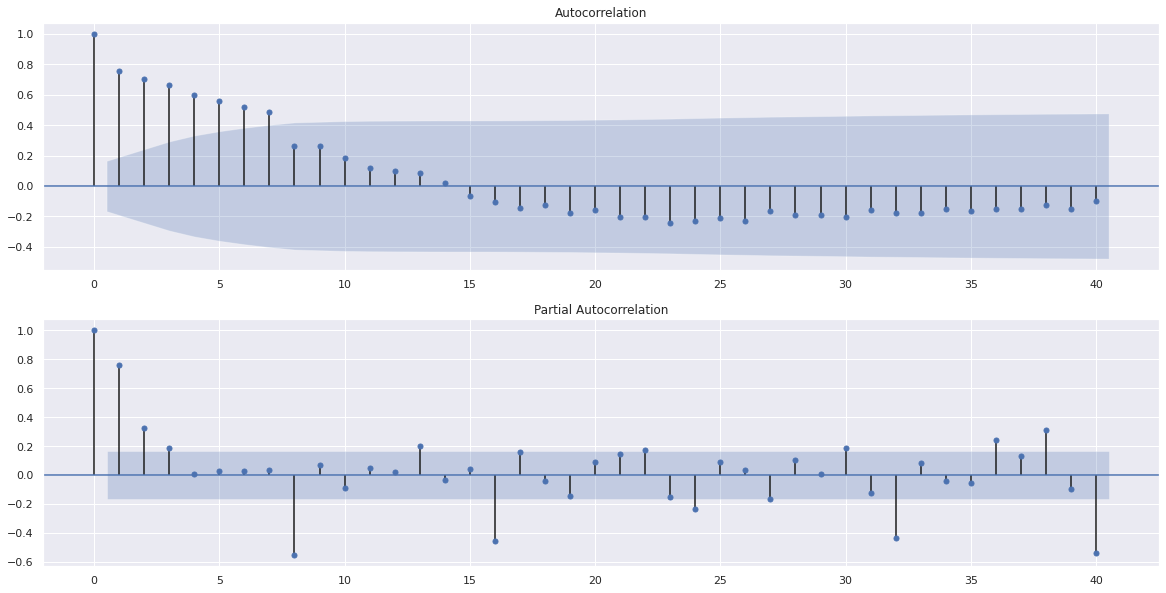

In [13]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(covid_esp_newcases.diff(8)['2020-02-24':], lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(covid_esp_newcases.diff(8)['2020-02-24':], lags=40, ax=ax[1])
plt.show()

In [ ]:
#resDiff = sm.tsa.arma_order_select_ic(covid_esp_newcases, max_ar=8, max_ma=8, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
# Grid Search
p = d = q = range(0,9) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
combs = {} # stores aic and order pairs
aics = [] # stores aics
# Grid Search continued
for combination in pdq:
    try:
        model = ARIMA(covid_esp_diff8.dropna(), order=combination) # create all possible models
        model = model.fit()
        combs.update({model.aic : combination}) # store combinations
        aics.append(model.aic)
    except:
        continue
        
best_aic = min(aics)

In [ ]:
combs[best_aic]

(8, 0, 7)

In [14]:
best_aic

NameError: ignored

In [17]:
# Model Creation and Forecasting. From the code above we get best_aic=2992.5536173498153 and order=(8, 0, 7)
#model = ARIMA(covid_esp_diff8.dropna(), order=combs[best_aic])

from statsmodels.tsa.arima_model import ARIMA

best_order=(8, 0, 7)
model = ARIMA(covid_esp_diff8.dropna(), order=best_order)
model = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


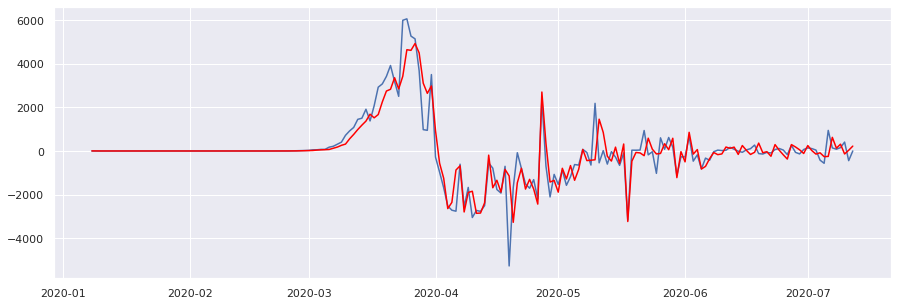

In [18]:
plt.plot(covid_esp_diff8)
plt.plot(model.fittedvalues, color='red')
plt.show()

In [126]:
covid_esp_diff8_fc = model.forecast(16)[0]
covid_esp_diff8_fc_s = pd.Series(covid_esp_diff8_fc)

In [53]:
covid_esp_diff8.shape

(195,)

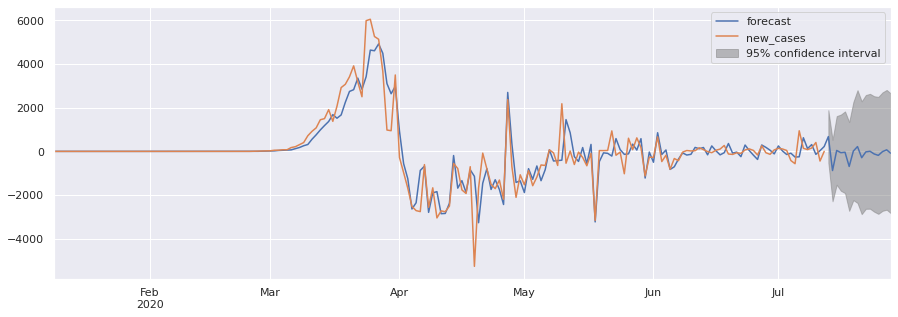

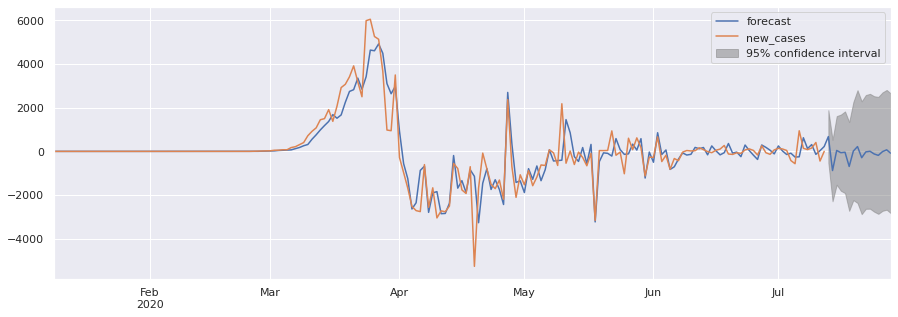

In [21]:
model.plot_predict(1,202)

In [86]:
periods = 8

restored = covid_esp_newcases.copy()
restored.iloc[periods:] = np.nan
for d, val in covid_esp_diff8.iloc[periods:].iteritems():
    restored.loc[d] = restored.loc[d - pd.DateOffset(days=periods)] + val

res = pd.concat([covid_esp_newcases, covid_esp_diff8, restored], axis=1)
res.columns = ['original', 'diffs', 'restored']
res.tail(15)

,original,diffs,restored
date,,,
2020-06-28,301.0,-62.0,301.0
2020-06-29,200.0,-134.0,200.0
2020-06-30,301.0,69.0,301.0
2020-07-01,388.0,140.0,388.0
2020-07-02,444.0,110.0,444.0
2020-07-03,442.0,42.0,442.0
2020-07-04,0.0,-419.0,0.0
2020-07-05,0.0,-564.0,0.0
2020-07-06,1244.0,943.0,1244.0


In [67]:
covid_esp_diff8_fc_s

0     678.335128
1    -876.183583
2      43.437697
3     -59.159018
4     -39.245726
5    -689.773963
6      14.651657
7     220.454064
8    -289.496447
9     -23.033341
10      5.804812
11   -117.475497
12   -182.205924
13    -10.398784
14     71.954093
15    -89.333704
dtype: float64

In [81]:
covid_esp_diff8_fc_s.index

DatetimeIndex(['2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28'],
              dtype='datetime64[ns]', freq=None)

In [127]:
import datetime


covid_esp_diff8_fc_s.index = [covid_esp_diff8.index[-1] + datetime.timedelta(days=1), covid_esp_diff8.index[-1] + datetime.timedelta(days=2), 
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=3), covid_esp_diff8.index[-1] + datetime.timedelta(days=4),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=5), covid_esp_diff8.index[-1] + datetime.timedelta(days=6),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=7), covid_esp_diff8.index[-1] + datetime.timedelta(days=8),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=9), covid_esp_diff8.index[-1] + datetime.timedelta(days=10),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=11), covid_esp_diff8.index[-1] + datetime.timedelta(days=12),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=13), covid_esp_diff8.index[-1] + datetime.timedelta(days=14),
                              covid_esp_diff8.index[-1] + datetime.timedelta(days=15), covid_esp_diff8.index[-1] + datetime.timedelta(days=16)]

#for i in range(0, 17):
#  datetime.datetime.fromtimestamp(covid_esp_diff8_fc_s.index[i])

covid_esp_diff8_fc_s

2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
dtype: float64

In [105]:
covid_esp_diff8.index[-1]

Timestamp('2020-07-12 00:00:00', freq='D')

In [106]:
covid_esp_diff8_fc_s.index[0]

Timestamp('2020-07-13 00:00:00', freq='D')

In [128]:
covid_esp_diff8_fc_s = covid_esp_diff8_fc_s.resample('D').sum()

In [129]:
covid_esp_diff8_fc_s

2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
Freq: D, dtype: float64

In [130]:
covid_esp_diff8plusfc = covid_esp_diff8.append(covid_esp_diff8_fc_s)

In [131]:
covid_esp_diff8plusfc.tail(20)

2020-07-09    155.000000
2020-07-10    408.000000
2020-07-11   -442.000000
2020-07-12      0.000000
2020-07-13    678.335128
2020-07-14   -876.183583
2020-07-15     43.437697
2020-07-16    -59.159018
2020-07-17    -39.245726
2020-07-18   -689.773963
2020-07-19     14.651657
2020-07-20    220.454064
2020-07-21   -289.496447
2020-07-22    -23.033341
2020-07-23      5.804812
2020-07-24   -117.475497
2020-07-25   -182.205924
2020-07-26    -10.398784
2020-07-27     71.954093
2020-07-28    -89.333704
Freq: D, dtype: float64

In [138]:
periods = 8

res_cov_es_fc = covid_esp_diff8plusfc.copy()
#res_cov_es_fc.iloc[periods:] = np.nan
for d, val in covid_esp_diff8plusfc.iloc[periods:].iteritems():
    res_cov_es_fc.loc[d] = covid_esp_diff8plusfc.loc[d - pd.DateOffset(days=periods)] + val

In [137]:
val

-89.33370397456207

In [139]:
res_cov_es_fc.tail(20)

2020-07-09    295.000000
2020-07-10    518.000000
2020-07-11   -400.000000
2020-07-12   -419.000000
2020-07-13    114.335128
2020-07-14     66.816417
2020-07-15    184.437697
2020-07-16     22.840982
2020-07-17    115.754274
2020-07-18   -281.773963
2020-07-19   -427.348343
2020-07-20    220.454064
2020-07-21    388.838681
2020-07-22   -899.216924
2020-07-23     49.242510
2020-07-24   -176.634515
2020-07-25   -221.451650
2020-07-26   -700.172747
2020-07-27     86.605750
2020-07-28    131.120360
Freq: D, dtype: float64

In [143]:
covid_esp_newcases.tail(10)

date
2020-07-03     442.0
2020-07-04       0.0
2020-07-05       0.0
2020-07-06    1244.0
2020-07-07     341.0
2020-07-08     383.0
2020-07-09     543.0
2020-07-10     852.0
2020-07-11       0.0
2020-07-12       0.0
Freq: D, Name: new_cases, dtype: float64

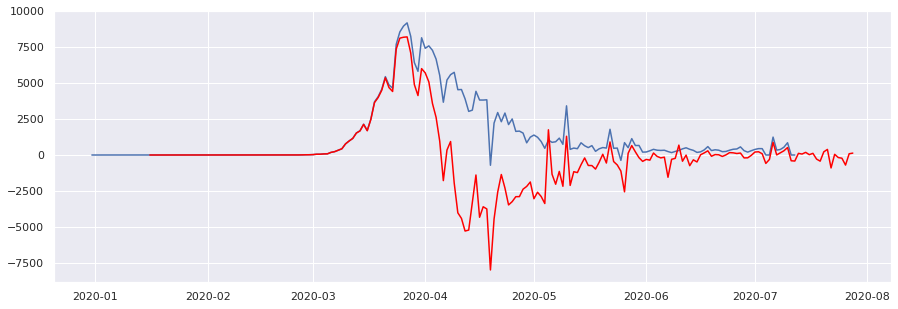

In [144]:
plt.plot(covid_esp_newcases)
plt.plot(res_cov_es_fc, color='red')
plt.show()